In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os.path
from enum import Enum
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from scipy.stats import uniform
from sklearn.metrics import make_scorer, cohen_kappa_score
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer

In [2]:
train_data = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv', index_col = 'id')
test_data = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/test.csv', index_col = 'id')
dictionary = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/data_dictionary.csv')
train_parquet_path = '/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet/'
test_parquet_path = '/kaggle/input/child-mind-institute-problematic-internet-use/series_test.parquet/'

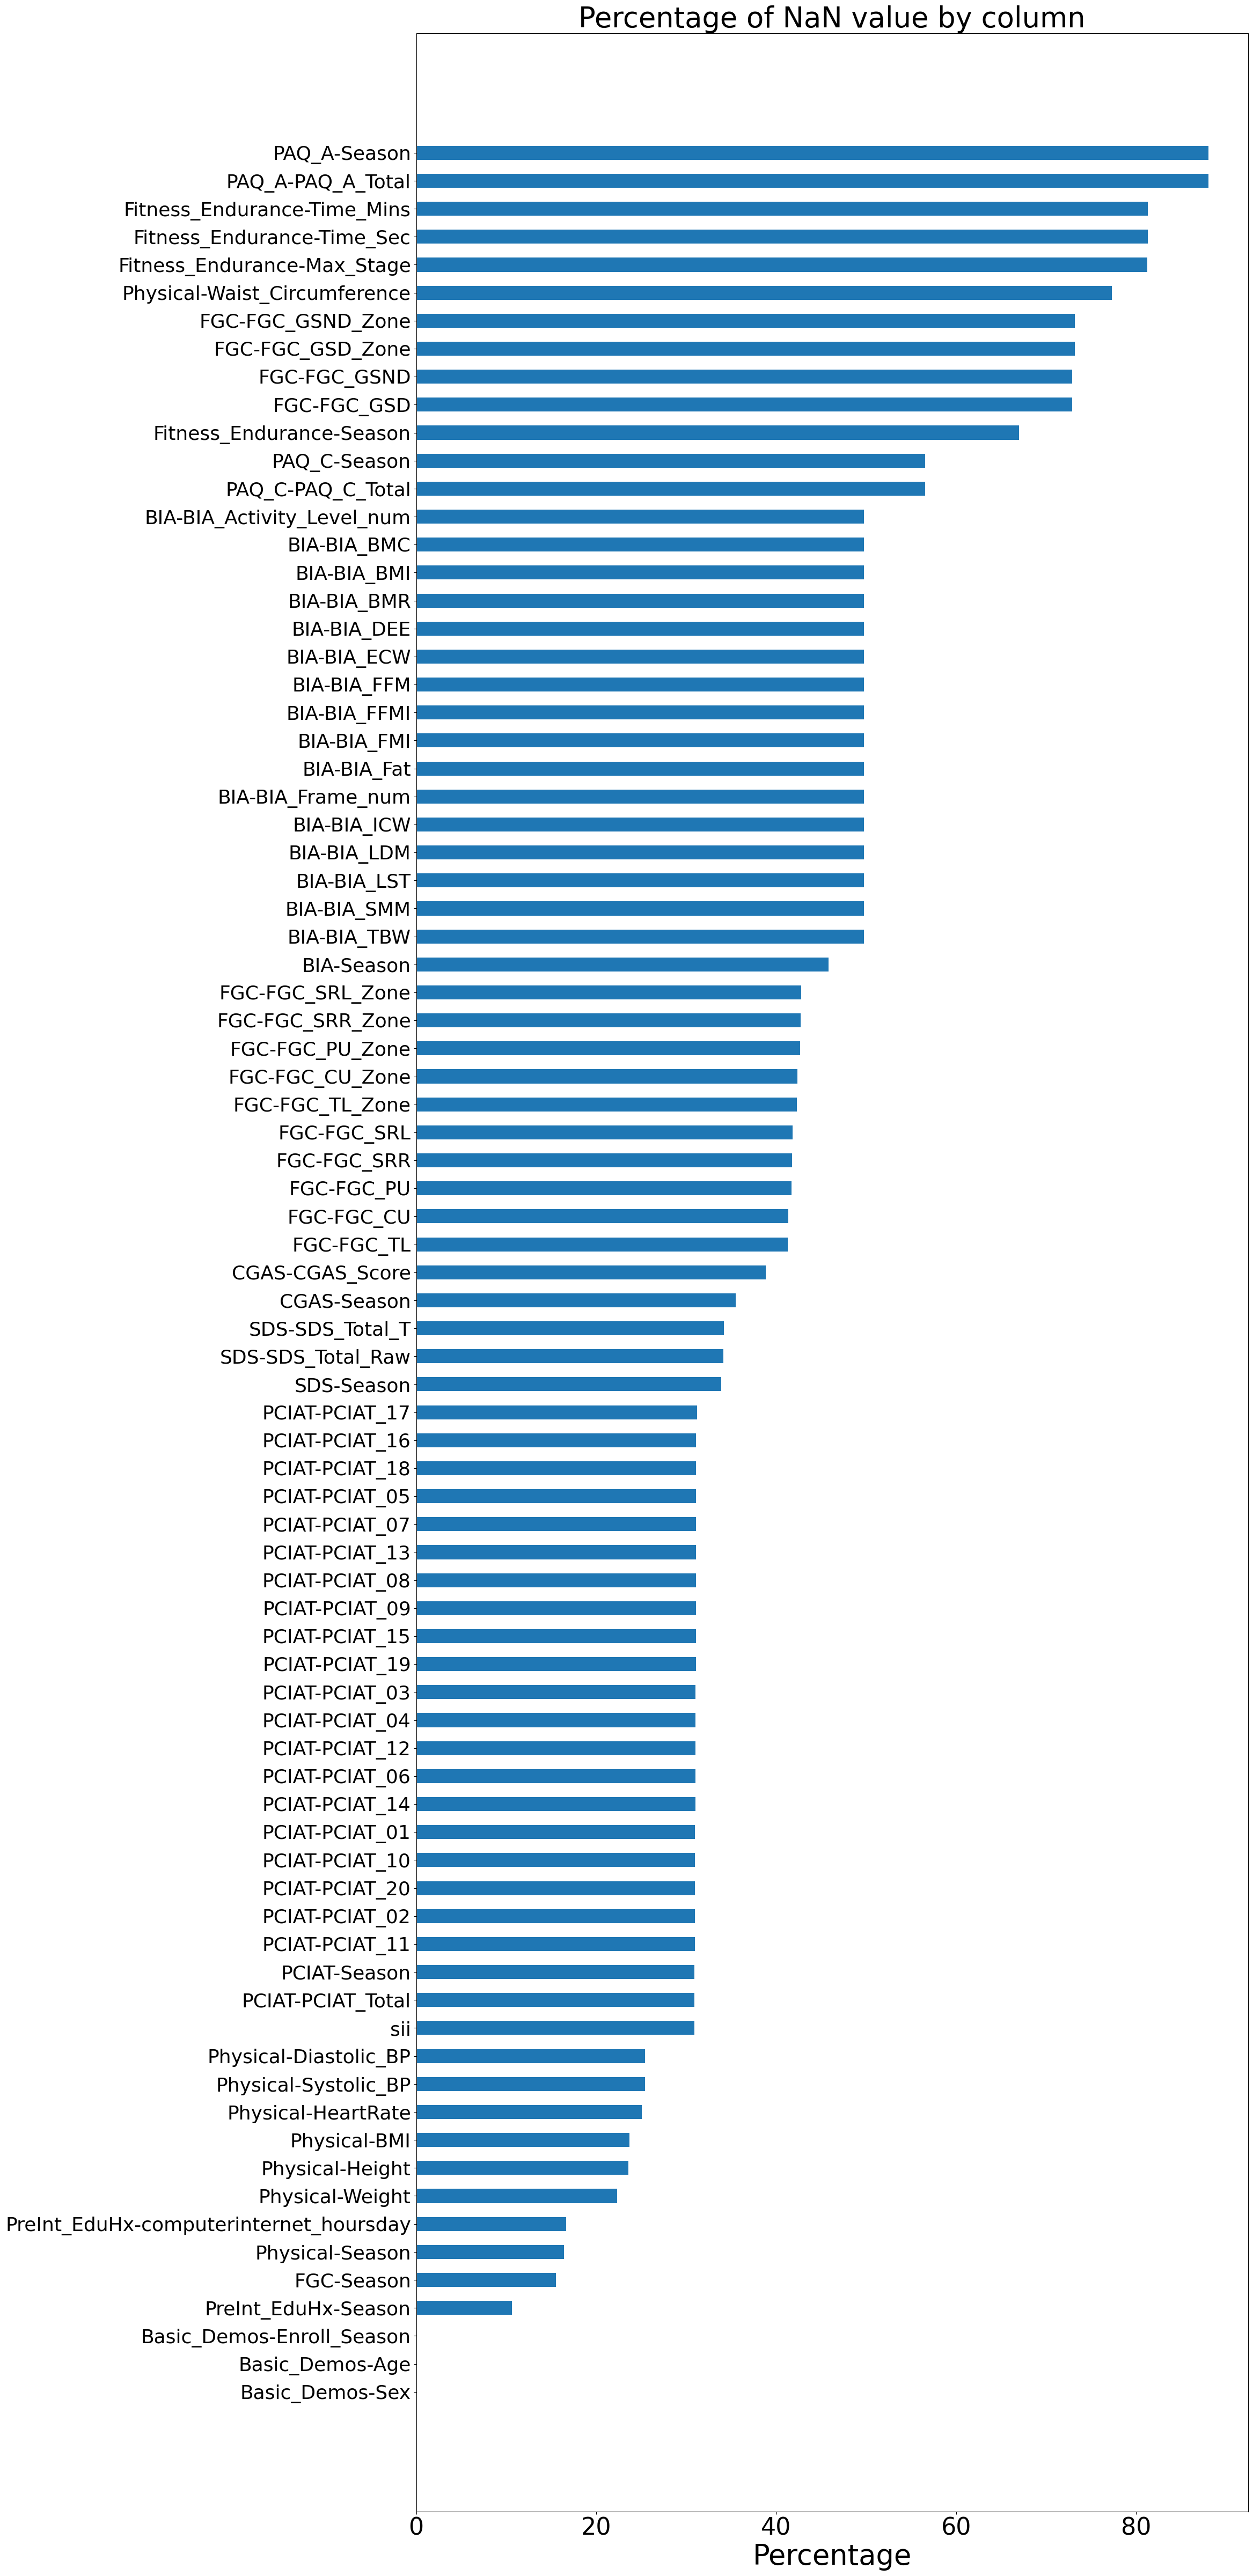

['PAQ_A-Season', 'PAQ_A-PAQ_A_Total', 'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec', 'Fitness_Endurance-Max_Stage', 'Physical-Waist_Circumference', 'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD_Zone', 'FGC-FGC_GSND', 'FGC-FGC_GSD', 'Fitness_Endurance-Season', 'PAQ_C-Season', 'PAQ_C-PAQ_C_Total']
13


In [3]:
missing_columns = []
def sortf(val):
    return val[1]
    
for col in train_data.columns:
    missing_columns.append([col, round(100 * (train_data[col].isnull().sum() / train_data[col].shape[0]), 2)])

missing_columns.sort(reverse=True, key=sortf)

fig, ax = plt.subplots(figsize=(20,60))
name = [x[0] for x in missing_columns]
y_pos = [4 * x for x in np.arange(len(train_data.columns))]
data = [x[1] for x in missing_columns]

ax.barh(y_pos, data, align='center', height=2)
ax.set_yticks(y_pos, labels=name, fontsize=26)
plt.xticks(fontsize=32)
ax.invert_yaxis()
ax.set_xlabel('Percentage', fontsize=38)
ax.set_title('Percentage of NaN value by column', fontsize=38)

plt.show()

#Drop columns with high percentage of NaN
columns_to_drop = [
    col[0] for col in missing_columns 
    if (col[1] >= 50)
]
print(columns_to_drop)
print(len(columns_to_drop))

train_data = train_data.drop(columns=columns_to_drop)

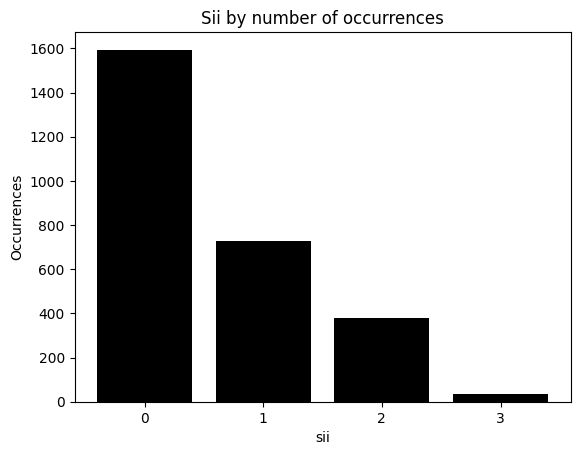

sii
0.0    1594
1.0     730
2.0     378
3.0      34
Name: count, dtype: int64


In [4]:
data = train_data[['PCIAT-PCIAT_Total', 'sii']]
plt.bar(['0','1','2','3'], data['sii'].value_counts().values,label="Bars 1",color="black")
plt.xlabel("sii")
plt.ylabel("Occurrences")
plt.title("Sii by number of occurrences")
plt.show()
print(data['sii'].value_counts())

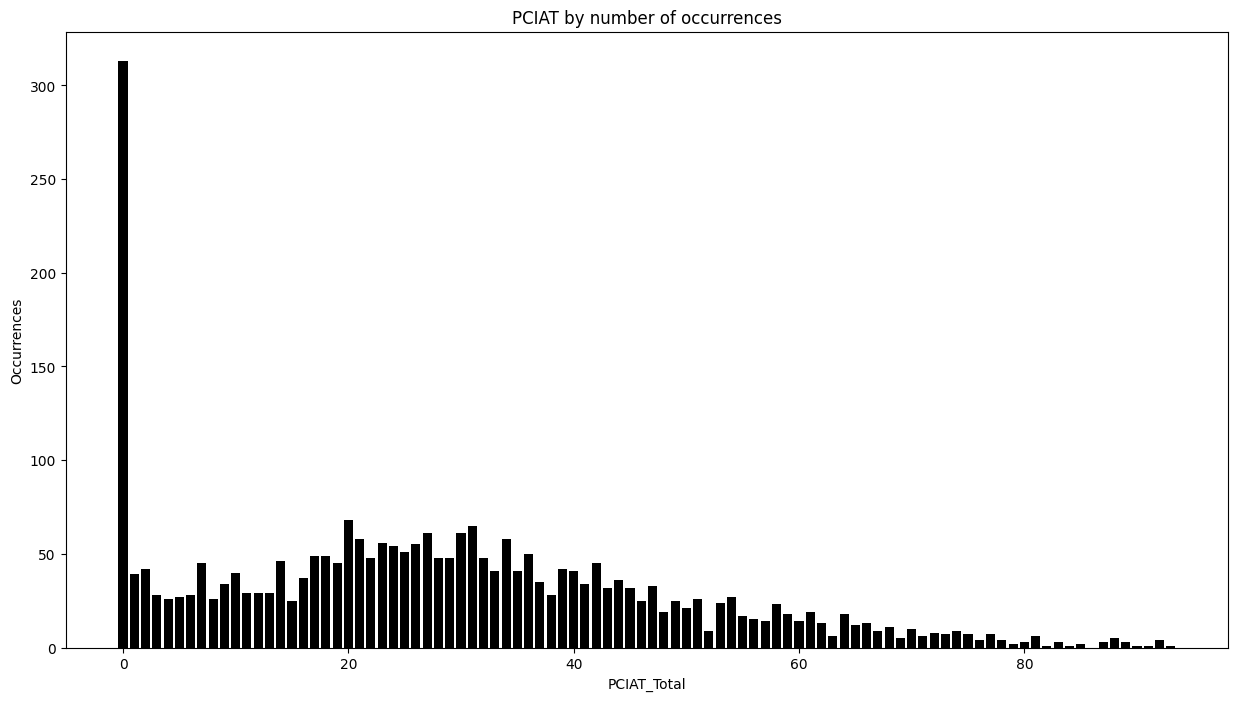

In [5]:
plt.figure(figsize=(15, 8))
plt.bar(data['PCIAT-PCIAT_Total'].value_counts().index, data['PCIAT-PCIAT_Total'].value_counts().values, label="Bars 1",color="black")
plt.xlabel("PCIAT_Total")
plt.ylabel("Occurrences")
plt.title("PCIAT by number of occurrences")
plt.show()

In [6]:
df = pd.DataFrame({
    "PCIAT_min": [int(data[data['sii'] == i].min()['PCIAT-PCIAT_Total']) for i in range(0,4)],
    "PCIAT_max": [int(data[data['sii'] == i].max()['PCIAT-PCIAT_Total']) for i in range(0,4)]
})
df.index.name = 'sii'

print(df)

     PCIAT_min  PCIAT_max
sii                      
0            0         30
1           31         49
2           50         79
3           80         93


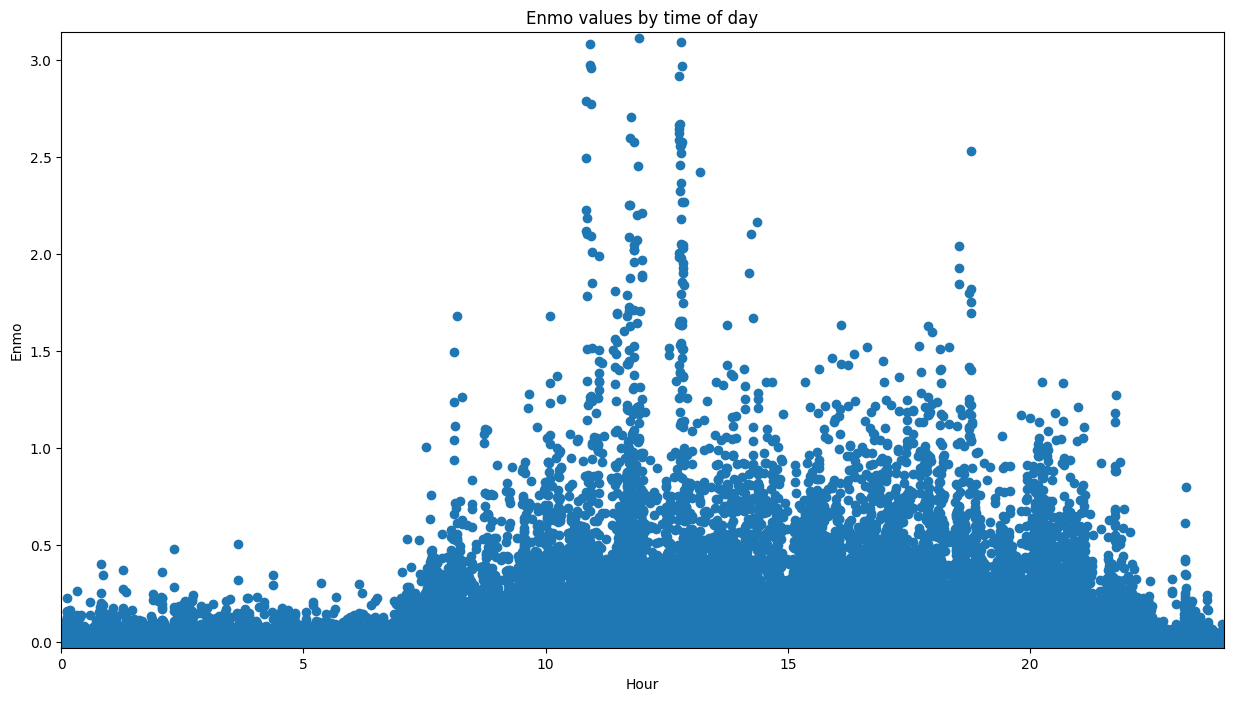

In [7]:
parquet_data = pd.read_parquet(train_parquet_path + "id=1911731d")
parquet_data = parquet_data.drop(parquet_data[parquet_data['non-wear_flag'] != 0].index)

plt.figure(figsize=(15, 8))
plt.margins(0, 0.01)
plt.scatter([x / 3.6e12 for x in parquet_data['time_of_day']], parquet_data['enmo'])
plt.xlabel("Hour")
plt.ylabel("Enmo")
plt.title("Enmo values by time of day")
plt.show()

In [8]:
parquet_ids = []
for filename in os.listdir(train_parquet_path):
  if filename.startswith('id='):
    parquet_ids.append(filename.split("=")[1])
for filename in os.listdir(test_parquet_path):
  if filename.startswith('id='):
    parquet_ids.append(filename.split("=")[1])


parquet_ids = set(parquet_ids).intersection(train_data.index).union(set(parquet_ids).intersection(test_data.index))


def parquet_reader(train, id):
    if id in parquet_ids:
        path = (train_parquet_path + "id=" + id) if train == True else (test_parquet_path + "id=" + id)
        parquet_data = pd.read_parquet(path)
        parquet_data = parquet_data.drop(parquet_data[parquet_data['non-wear_flag'] != 0].index)
        parquet_data = parquet_data.drop(parquet_data[parquet_data['time_of_day'] < 6 * 3.6e12].index)
        parquet_data = parquet_data.drop(parquet_data[parquet_data['time_of_day'] > 23 * 3.6e12].index)
        return [
            parquet_data['enmo'].mean(),
            parquet_data['enmo'].median(),
            parquet_data['enmo'].std(),
            parquet_data['anglez'].std(),
            parquet_data['light'].std(),
           ]
    else:
        return [np.nan, np.nan, np.nan, np.nan, np.nan]
def add_parquet(train, df):
    index = train_data.index if train == True else test_data.index
    df[['Enmo_mean',
        'Enmo_median',
        'Enmo_std',
        'Angle_std', 
        'Light_std'
       ]] = [parquet_reader(train, x) for x in index]
    return df

train_data = add_parquet(True, train_data)

In [9]:
def feature_engineering(df):
    df['BMI_Age'] = df['Physical-BMI'] * df['Basic_Demos-Age']
    df['Internet_Hours_Age'] = df['PreInt_EduHx-computerinternet_hoursday'] * df['Basic_Demos-Age']
    df['BMI_Internet_Hours'] = df['Physical-BMI'] * df['PreInt_EduHx-computerinternet_hoursday']
    df['BFP_BMI'] = df['BIA-BIA_Fat'] / df['BIA-BIA_BMI']
    df['FFMI_BFP'] = df['BIA-BIA_FFMI'] / df['BIA-BIA_Fat']
    df['FMI_BFP'] = df['BIA-BIA_FMI'] / df['BIA-BIA_Fat']
    df['LST_TBW'] = df['BIA-BIA_LST'] / df['BIA-BIA_TBW']
    df['BFP_BMR'] = df['BIA-BIA_Fat'] * df['BIA-BIA_BMR']
    df['BFP_DEE'] = df['BIA-BIA_Fat'] * df['BIA-BIA_DEE']
    df['BMR_Weight'] = df['BIA-BIA_BMR'] / df['Physical-Weight']
    df['DEE_Weight'] = df['BIA-BIA_DEE'] / df['Physical-Weight']
    df['SMM_Height'] = df['BIA-BIA_SMM'] / df['Physical-Height']
    df['Muscle_to_Fat'] = df['BIA-BIA_SMM'] / df['BIA-BIA_FMI']
    df['Hydration_Status'] = df['BIA-BIA_TBW'] / df['Physical-Weight']
    df['ICW_TBW'] = df['BIA-BIA_ICW'] / df['BIA-BIA_TBW']
    df['BMI_PHR'] = df['Physical-BMI'] * df['Physical-HeartRate']
    return df

train_data = feature_engineering(train_data)

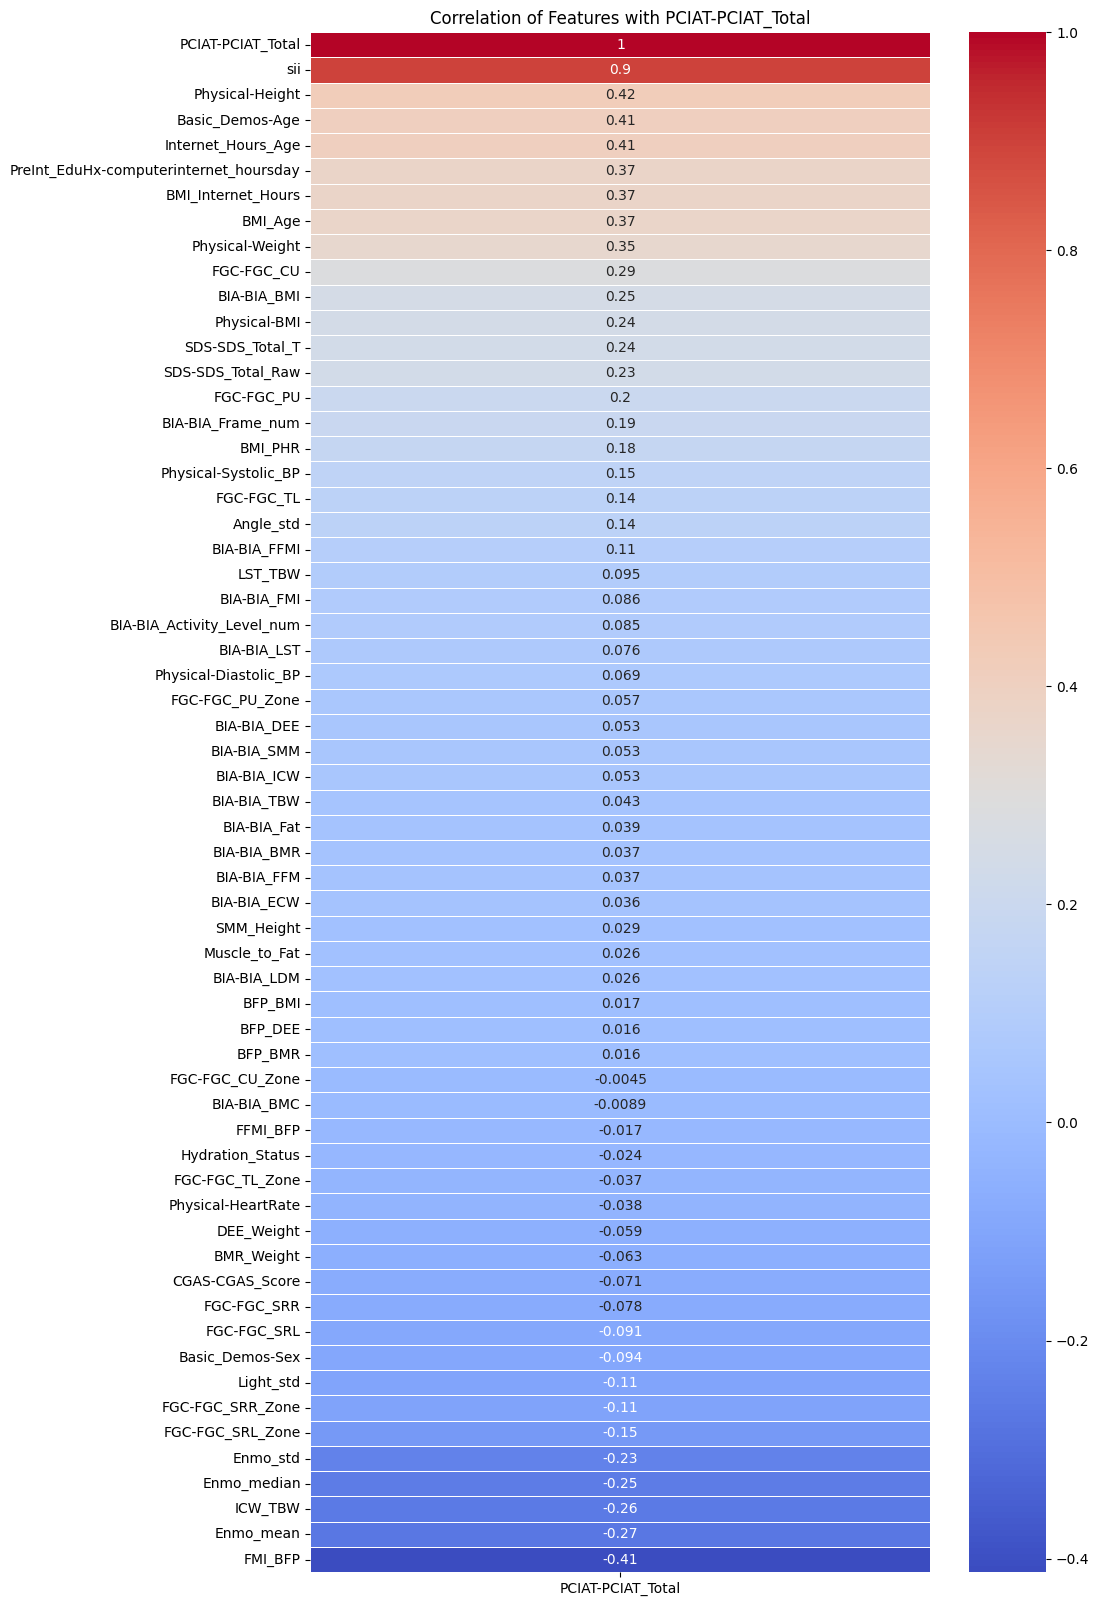

['LST_TBW', 'BIA-BIA_FMI', 'BIA-BIA_Activity_Level_num', 'BIA-BIA_LST', 'Physical-Diastolic_BP', 'FGC-FGC_PU_Zone', 'BIA-BIA_DEE', 'BIA-BIA_SMM', 'BIA-BIA_ICW', 'BIA-BIA_TBW', 'BIA-BIA_Fat', 'BIA-BIA_BMR', 'BIA-BIA_FFM', 'BIA-BIA_ECW', 'SMM_Height', 'Muscle_to_Fat', 'BIA-BIA_LDM', 'BFP_BMI', 'BFP_DEE', 'BFP_BMR', 'FGC-FGC_CU_Zone', 'BIA-BIA_BMC', 'FFMI_BFP', 'Hydration_Status', 'FGC-FGC_TL_Zone', 'Physical-HeartRate', 'DEE_Weight', 'BMR_Weight', 'CGAS-CGAS_Score', 'FGC-FGC_SRR', 'FGC-FGC_SRL', 'Basic_Demos-Sex', 'Basic_Demos-Enroll_Season', 'CGAS-Season', 'Physical-Season', 'FGC-Season', 'BIA-Season', 'PCIAT-Season', 'PCIAT-PCIAT_01', 'PCIAT-PCIAT_02', 'PCIAT-PCIAT_03', 'PCIAT-PCIAT_04', 'PCIAT-PCIAT_05', 'PCIAT-PCIAT_06', 'PCIAT-PCIAT_07', 'PCIAT-PCIAT_08', 'PCIAT-PCIAT_09', 'PCIAT-PCIAT_10', 'PCIAT-PCIAT_11', 'PCIAT-PCIAT_12', 'PCIAT-PCIAT_13', 'PCIAT-PCIAT_14', 'PCIAT-PCIAT_15', 'PCIAT-PCIAT_16', 'PCIAT-PCIAT_17', 'PCIAT-PCIAT_18', 'PCIAT-PCIAT_19', 'PCIAT-PCIAT_20', 'SDS-Season', '

In [10]:
# Convert all columns to numeric where possible, coercing errors for non-numeric data
df_numeric = train_data.apply(pd.to_numeric, errors='coerce')
columns_to_exclude = [
    col for col in df_numeric.columns 
    if (col.startswith("PCIAT-PCIAT_") and col != "PCIAT-PCIAT_Total") or col.endswith("Season")
]

filtered_df = df_numeric.drop(columns=columns_to_exclude, errors='ignore')

# Compute correlation matrix
correlation_matrix = filtered_df.corr()

# Extract correlations with PCIAT-PCIAT_Total
pciat_correlations = correlation_matrix["PCIAT-PCIAT_Total"].sort_values(ascending=False)

# Plot correlation heatmap
plt.figure(figsize=(10, 20))

sns.heatmap(pciat_correlations.to_frame(), annot=True, cmap="coolwarm", cbar=True, linewidths=0.5)

plt.title("Correlation of Features with PCIAT-PCIAT_Total")

plt.show()

columns_to_remove = [index for index, row in pciat_correlations.to_frame().itertuples() if abs(row) < 0.1]
columns_to_drop.extend(columns_to_remove)

columns_to_remove.extend(columns_to_exclude)
print(columns_to_remove)

#Drop columns with low correlation with the result
train_data = train_data.drop(columns=columns_to_remove)

print(len(columns_to_remove))


In [11]:
def impute(df):
    imputed_data = imputer.transform(df)
    return pd.DataFrame(imputed_data, columns=df.columns)

In [12]:
train_data = train_data.dropna(subset=['PCIAT-PCIAT_Total'])
train_data['sii'] = train_data['sii'].astype(int)
imputer = KNNImputer(n_neighbors=5)
X = train_data.drop(columns=['PCIAT-PCIAT_Total', 'sii'])
imputer.fit(X)
X = impute(X)

y = train_data['PCIAT-PCIAT_Total']

In [13]:
model = XGBRegressor(objective='reg:squarederror')
def sii_converter(scores):
    array = np.zeros_like(scores, dtype=int)
    for index, value in enumerate(scores):
        value = value * 1.252
        if value <= 30:
            array[index] = 0
        elif value < 50:
            array[index] = 1
        elif value < 80:
            array[index] = 2
        else:
            array[index] = 3
    return array
    
def kappa_scorer(true_vls, pred_vls):
    return cohen_kappa_score(sii_converter(true_vls), sii_converter(pred_vls), weights='quadratic')
scorer = make_scorer(kappa_scorer, greater_is_better=True)

In [14]:
params = {
    'max_depth': stats.randint(3, 20),
    'learning_rate': stats.uniform(0.01, 0.12),
    'subsample': stats.uniform(0.5, 0.5),
    'n_estimators':stats.randint(30, 200),
    'colsample_bytree': stats.uniform(0.5, 0.5),
    'reg_alpha': stats.randint(0, 5),
    'reg_lambda': stats.randint(0, 5),
}


# random_search = RandomizedSearchCV(estimator=model,param_distributions=params, n_iter=120, scoring=scorer,cv=5, n_jobs = -1)
# random_search.fit(X, y)
# print(random_search.best_params_)


optimal_params = {'colsample_bytree': 0.6359724107842156, 'learning_rate': 0.03512019724818933, 'max_depth': 7, 'n_estimators': 175, 'reg_alpha': 2, 'reg_lambda': 4, 'subsample': 0.6290658895617779}

In [15]:
predictor = XGBRegressor(**optimal_params)

predictor.fit(X, y)

test_ids = test_data.index
columns_to_drop.extend([
    col for col in test_data.columns 
    if col.endswith("Season")
])

test_data = add_parquet(False, test_data)
test_data = feature_engineering(test_data)
test_data = test_data.drop(columns=columns_to_drop, errors='ignore')
imputer.fit(pd.concat([X, test_data]))
test_data = impute(test_data)

predictions = predictor.predict(test_data)

In [16]:
output = pd.DataFrame({
    'id': test_ids,
    'sii': sii_converter(predictions)
})
output.to_csv('submission.csv', index=False)

In [17]:
output

,id,sii
0,00008ff9,1
1,000fd460,0
2,00105258,1
3,00115b9f,1
4,0016bb22,2
5,001f3379,1
6,0038ba98,1
7,0068a485,0
8,0069fbed,2
9,0083e397,2
